<a href="https://colab.research.google.com/github/jainamtapiawala/ISPA-Case-Study/blob/main/ISPA_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== One-Sample t-test ===
Sample mean BMI = 297.00, n = 2111
t-statistic = 155.995, p-value = 0.00000
→ Reject H0: Mean BMI is significantly different from 25.



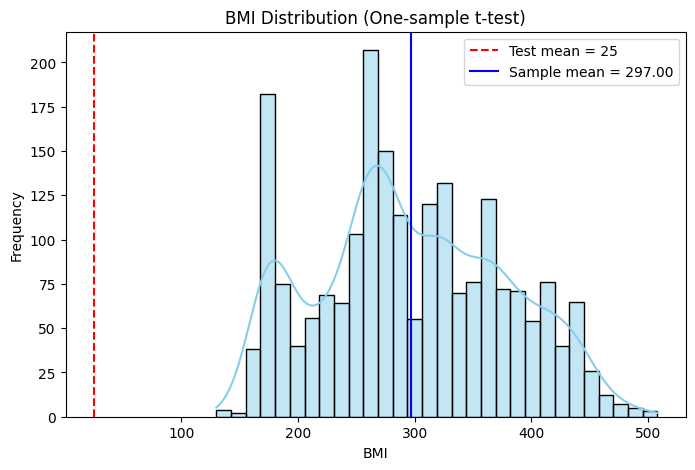

=== Two-Sample t-test (Welch) ===
Groups compared: Female (n=1043) vs Male (n=1068)
Mean Female = 301.30, Mean Male = 292.80
Levene’s test: stat = 185.804, p = 0.00000
t-statistic = 2.428, p-value = 0.01527
→ Reject H0: Significant BMI difference between the two groups.



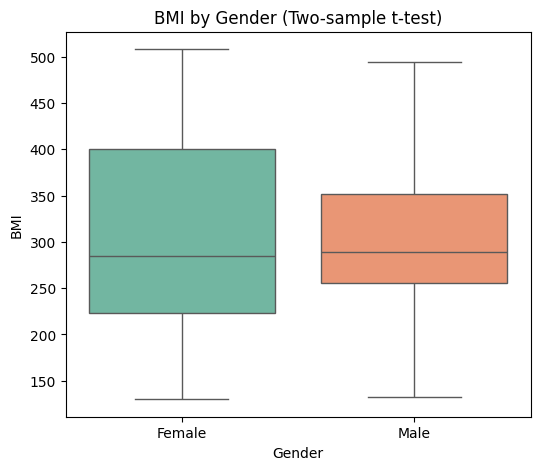

=== One-way ANOVA ===
                sum_sq      df          F        PR(>F)
C(CAEC)   2.512543e+06     3.0  159.98927  2.015034e-93
Residual  1.102976e+07  2107.0        NaN           NaN
→ Reject H0: At least one group mean differs significantly.



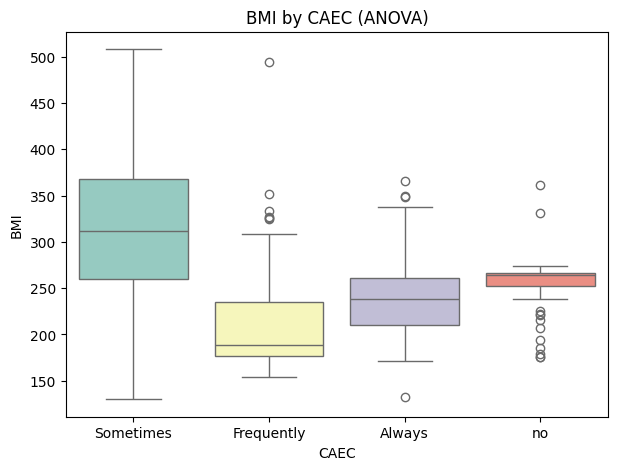

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv("/content/ObesityDataSet.csv")

# ---------------------------
# Step 1: Compute BMI correctly
# ---------------------------
weight_col = "Weight"   # change if dataset uses another name
height_col = "Height"   # change if dataset uses another name

df['weight_kg'] = pd.to_numeric(df[weight_col], errors='coerce') / 1000.0
df['height_m']  = pd.to_numeric(df[height_col], errors='coerce') / 100.0
df['BMI_corrected'] = df['weight_kg'] / (df['height_m'] ** 2)

# ---------------------------
# Step 2: One-sample t-test
# ---------------------------
bmi = df['BMI_corrected'].dropna()
t_stat, p_val = stats.ttest_1samp(bmi, 25.0)

print("=== One-Sample t-test ===")
print(f"Sample mean BMI = {bmi.mean():.2f}, n = {len(bmi)}")
print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.5f}")
if p_val < 0.05:
    print("→ Reject H0: Mean BMI is significantly different from 25.\n")
else:
    print("→ Fail to reject H0: Mean BMI is not significantly different from 25.\n")

# Plot histogram with population mean reference
plt.figure(figsize=(8,5))
sns.histplot(bmi, bins=30, kde=True, color="skyblue")
plt.axvline(25, color="red", linestyle="--", label="Test mean = 25")
plt.axvline(bmi.mean(), color="blue", linestyle="-", label=f"Sample mean = {bmi.mean():.2f}")
plt.title("BMI Distribution (One-sample t-test)")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# ---------------------------
# Step 3: Two-sample t-test
# ---------------------------
gender_col = "Gender"
groups = df[[gender_col, 'BMI_corrected']].dropna()
names = groups[gender_col].unique().tolist()

print("=== Two-Sample t-test (Welch) ===")
if len(names) == 2:
    g1 = groups[groups[gender_col] == names[0]]['BMI_corrected']
    g2 = groups[groups[gender_col] == names[1]]['BMI_corrected']

    levene_stat, levene_p = stats.levene(g1, g2)
    t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)

    print(f"Groups compared: {names[0]} (n={len(g1)}) vs {names[1]} (n={len(g2)})")
    print(f"Mean {names[0]} = {g1.mean():.2f}, Mean {names[1]} = {g2.mean():.2f}")
    print(f"Levene’s test: stat = {levene_stat:.3f}, p = {levene_p:.5f}")
    print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.5f}")

    if p_val < 0.05:
        print("→ Reject H0: Significant BMI difference between the two groups.\n")
    else:
        print("→ Fail to reject H0: No significant BMI difference between the groups.\n")

    # Boxplot of BMI by gender (fixing warning by using hue)
    plt.figure(figsize=(6,5))
    sns.boxplot(data=groups, x=gender_col, y="BMI_corrected", hue=gender_col,
                palette="Set2", legend=False)
    plt.title("BMI by Gender (Two-sample t-test)")
    plt.ylabel("BMI")
    plt.show()
else:
    print("Two-sample test skipped: Gender column is not binary.\n")

# ---------------------------
# Step 4: One-way ANOVA
# ---------------------------
anova_col = "CAEC"  # categorical column with multiple groups
anova_df = df[[anova_col, 'BMI_corrected']].dropna()
model = ols(f'BMI_corrected ~ C({anova_col})', data=anova_df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

print("=== One-way ANOVA ===")
print(anova_results)

p_val = anova_results["PR(>F)"].iloc[0]  # FIX: use .iloc for first row
if p_val < 0.05:
    print("→ Reject H0: At least one group mean differs significantly.\n")
else:
    print("→ Fail to reject H0: No significant differences among group means.\n")

# Boxplot of BMI across categories (fixing warning by using hue)
plt.figure(figsize=(7,5))
sns.boxplot(data=anova_df, x=anova_col, y="BMI_corrected", hue=anova_col,
            palette="Set3", legend=False)
plt.title(f"BMI by {anova_col} (ANOVA)")
plt.ylabel("BMI")
plt.show()
